In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brian2 import *

In [2]:
def make_gamma_spike_train(k, rate, tend=None, Nev=None, refractory_period=0, random_state=None):
    from scipy.stats import gamma
    if Nev is None and tend is not None:
        Nev = int(np.ceil(tend * rate * 1.5))
    ISIs = []
    while len(ISIs) < Nev:
        ISI = gamma.rvs(k, loc=0, scale=1 / (k * rate), size=1, random_state=random_state)
        if ISI > refractory_period:
            ISIs.append(ISI)
    spks = np.cumsum(ISIs)
    if tend is not None:
        spks = spks[spks < tend]
    return spks


make_poisson_spike_train = lambda rate, tend=None, Nev=None, refractory_period=0, random_state=None: \
    make_gamma_spike_train(1, rate, tend, Nev, refractory_period, random_state)

In [3]:
facilitating = False
if facilitating:
    pars = {
        'tau_mem': 60,
        'R_in': 1000,
        'pre_rate': [15, 30, 60],
        'tau_inact': 1.5,
        'tau_rec': 130,
        'tau_facil': 530,
        'A_SE': 1540,
        'U_SE': 0.03
    }
else:
    pars = {
        'tau_mem': 40,
        'R_in': 100,
        'pre_rate': [15, 30, 60],
        'tau_inact': 3,
        'tau_rec': 800,
        'A_SE': 250,
        'U_SE': 0.6
    }

In [4]:
neuron_eqs =  """
tau_mem : second
I_syn : ampere
R_in : ohm
dV/dt = -V/tau_mem + (R_in*I_syn)/tau_mem : volt
"""
neuron = NeuronGroup(1, neuron_eqs, method='exact', name='neuron')
neuron.tau_mem = pars['tau_mem']*ms
neuron.R_in = pars['R_in']*Mohm

In [5]:
pre_firing_rates = pars['pre_rate']*Hz
n_pre = 1000
stim_dur = 0.5 # [s]
t_before = 0.1 # [s]
pre_spike_times = [[make_poisson_spike_train(rate, tend=stim_dur, refractory_period=1e-3)+i*stim_dur \
                    for _ in range(n_pre)] for i,rate in enumerate(pre_firing_rates)]
indices = [[i+np.zeros(spks.size) for i,spks in enumerate(spikes)] for spikes in pre_spike_times]
poisson_pre = SpikeGeneratorGroup(n_pre,
                                  np.concatenate([np.concatenate(idx) for idx in indices]),
                                  (np.concatenate([np.concatenate(spks) for spks in pre_spike_times]) \
                                   + t_before)*second,
                                  name='stimulus')

In [6]:
synapse_eqs = """
dx/dt =  z/tau_rec : 1 (clock-driven)    # fraction recovered
dy/dt = -y/tau_inact  : 1 (clock-driven) # fraction active
z = 1 - x - y : 1                        # fraction inactive
A_SE : ampere
U_SE : 1
tau_rec : second
tau_inact : second
I_syn_post = A_SE*y : ampere (summed)
"""

if facilitating:
    synapse_eqs = synapse_eqs + """
    du/dt = -u/tau_facil : 1 (clock-driven)
    tau_facil : second
    """
    synapse_actions = """
    u += U_SE*(1-u)
    y += u*x
    x -= u*x
    """
else:
    synapse_actions = """
    y += U_SE*x
    x -= U_SE*x
    """

synapses = Synapses(poisson_pre, neuron, model=synapse_eqs, on_pre=synapse_actions, method='exponential_euler')
synapses.connect(p=1)
synapses.x = 1
synapses.y = 0
synapses.tau_inact = pars['tau_inact']*ms
synapses.tau_rec = pars['tau_rec']*ms
if facilitating:
    synapses.tau_facil = pars['tau_facil']*ms
synapses.A_SE = pars['A_SE']*pA
synapses.U_SE = pars['U_SE']

In [7]:
neuron_mon = StateMonitor(neuron, ['V'], record=True)
synapses_mon = StateMonitor(synapses, ['x','y'], record=True)

In [8]:
tend = (pre_firing_rates.size * stim_dur + t_before + 0.1) * second
defaultclock.dt = 0.025*ms
run(tend)
t = neuron_mon.t/ms
y = synapses_mon.y
I_syn = np.sum(y * pars['A_SE']*pA, axis=0) / nA

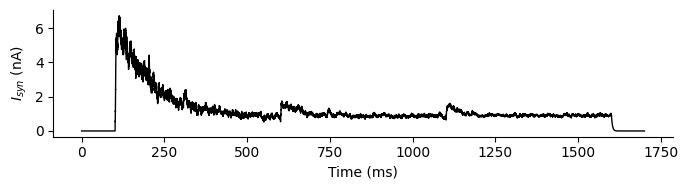

In [9]:
fig,ax = plt.subplots(1, 1, figsize=(7,2))
ax.plot(t, I_syn, 'k', lw=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'$I_{syn}$ (nA)')
sns.despine()
fig.tight_layout()